<a href="https://colab.research.google.com/github/tlalarus/charuco/blob/main/charuco_coverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Corner coverage visualizer
### 사용법
1. 런타임 -> 모두 실행
2. 입력 파일명 패턴: corners_*.yaml
3. 결과: coverage_overview.png 생성 + 화면표시

In [1]:
!pip -q install pyyaml opencv-python

In [2]:
import os, glob, yaml
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

search_dir = '/content/drive/My Drive/Colab Notebooks/data'

Mounted at /content/drive


In [6]:
# --- Settings
width, height = 640, 480
search_dir = '/content/drive/My Drive/Colab Notebooks/data/result'
pattern = os.path.join(search_dir, 'corners_*.yaml')

In [7]:
palette = [
    (230, 25, 75),
    (60, 180, 75),
    (255, 225, 25),
    (0, 130, 200),
    (245, 130, 48),
    (145, 30, 180),
    (70, 240, 240),
    (240, 50, 230),
    (210, 245, 60),
    (250, 190, 190),
]

In [8]:
def _to_pts(arr):
  a = np.array(arr, dtype=np.float32)
  if a.size == 0:
    return np.zeros((0,2), dtype=np.float32)
  a = a.reshape(-1, 2)
  return a


In [9]:
def load_corners2d(yaml_path):
  """corners2d가 dict/list/멀티문서 형태 등 다양한 yaml을 안전하게 파싱"""
  with open(yaml_path, "r") as f:
    try:
      data = yaml.safe_load(f)
    except yaml.YAMLError:
      f.seek(0)
      docs = list(yaml.safe_load_all(f))
      data = docs if len(docs) > 1 else (docs[0] if docs else None)

  if data is None:
    return np.zeros((0,2), dtype=np.float32)

  if isinstance(data, dict):
    if 'corners2d' in data:
      return _to_pts(data["corners2d"])
    for k, v in data.items():
      if isinstance(k, str) and "corner" in k.lower():
        return _to_pts(v)
    return np.zeros((0,2), dtype=np.float32)

  if isinstance(data, list):
    if len(data) > 0 and isinstance(data[0], dict):
      for d in data:
        if "corners2d" in d:
          return _to_pts(d['corners2d'])
        for k, v in d.items():
          if isinstance(k, str) and "corner" in k.lower():
            return _to_pts(v)

      return np.zeros((0,2), dtype=np.float32)
    else:
      return _to_pts(data)

  return np.zeros((0,2), dtype=np.float32)



In [11]:
files = sorted(glob.glob(pattern))
if not files:
  print(f"No yaml files found: {pattern}")

files

['/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_01.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_02.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_03.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_04.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_07.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_08.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_09.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_11.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_side_12.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_top_01.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_top_02.yaml',
 '/content/drive/My Drive/Colab Notebooks/data/result/corners_tv_top_03.yaml',
 '/content/drive/My Drive/Colab Notebooks/d

In [12]:
canvas = np.full((height, width, 3), 255, dtype=np.uint8)
labels = []

for idx, path in enumerate(files):
  color = palette[idx % len(palette)]
  pts = load_corners2d(path)

  # draw corners
  for (u, v) in pts:
    u_i = int(round(u)); v_i = int(round(v))
    if 0 <= u_i < width and 0 <= v_i < height:
      cv2.circle(canvas, (u_i, v_i), 2, color, thickness=-1, lineType=cv2.LINE_AA)

  # Convex Hull
  if len(pts) >= 3:
    hull = cv2.convexHull(pts.reshape(-1,1,2))
    cv2.polylines(canvas, [hull.astype(np.int32)], isClosed=True, color=color, thickness=2, lineType=cv2.LINE_AA)

  labels.append(os.path.basename(path))

In [13]:
labels

['corners_tv_side_01.yaml',
 'corners_tv_side_02.yaml',
 'corners_tv_side_03.yaml',
 'corners_tv_side_04.yaml',
 'corners_tv_side_07.yaml',
 'corners_tv_side_08.yaml',
 'corners_tv_side_09.yaml',
 'corners_tv_side_11.yaml',
 'corners_tv_side_12.yaml',
 'corners_tv_top_01.yaml',
 'corners_tv_top_02.yaml',
 'corners_tv_top_03.yaml',
 'corners_tv_top_04.yaml',
 'corners_tv_top_05.yaml',
 'corners_tv_top_06.yaml',
 'corners_tv_top_07.yaml',
 'corners_tv_top_08.yaml',
 'corners_tv_top_09.yaml',
 'corners_tv_top_10.yaml',
 'corners_tv_top_11.yaml']

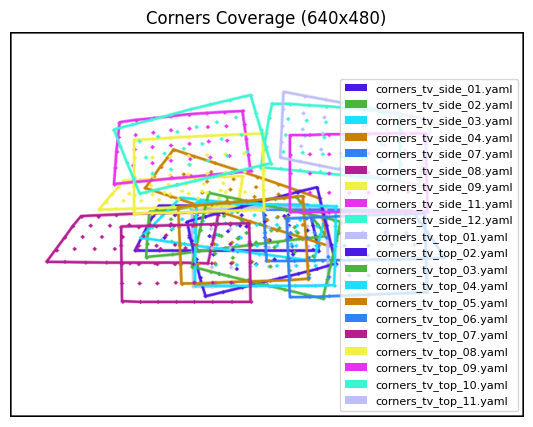

In [17]:
# 외곽 프레임 테두리
cv2.rectangle(canvas, (0,0), (width-1, height-1), (0,0,0), 2)

out_path = os.path.join(search_dir, "coverage_overview.png")
cv2.imwrite(out_path, canvas[:, :, ::-1]) # rgb

plt.figure(figsize=(7,5))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Corners Coverage (640x480)")
plt.axis('off')

legend_patches = [Patch(facecolor=np.array(palette[i % len(palette)][::-1])/255.0, edgecolor='none')
                  for i in range(len(files))]
plt.legend(handles=legend_patches, labels=labels, loc='lower right', fontsize=8)
plt.show()